In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
root_dir ="/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/"
extra_path = ("DDims_NewLongerDriftEvalExp_MSEs_10240NPaths_TRACK").replace(
            ".", "")
score_eval=pd.read_parquet(root_dir + extra_path+ "_score_MSE.parquet", engine="fastparquet")
nad_eval=pd.read_parquet(root_dir + extra_path+ "_nad_MSE.parquet")
nad_eval_true_law=pd.read_parquet(root_dir + extra_path+"_nad_true_law_MSE.parquet")
score_eval_true_law=pd.read_parquet(root_dir + extra_path+"_score_true_law_MSE.parquet")
score_state_eval=pd.read_parquet(root_dir + extra_path+ "_score_state_MSE.parquet")
nad_state_eval=pd.read_parquet(root_dir + extra_path+ "_nad_state_MSE.parquet")
stable_state_eval = (pd.concat([score_state_eval.rename({d:d+" Score State" for d in score_state_eval.columns}, axis=1),nad_state_eval.rename({d:d+" Nadaraya State" for d in score_state_eval.columns}, axis=1)], axis=1))
stable_true_law_eval = (pd.concat([score_eval_true_law.rename({d:d+" Score True" for d in score_state_eval.columns}, axis=1),nad_eval_true_law.rename({d:d+" Nadaraya True" for d in score_state_eval.columns}, axis=1)], axis=1))
stable_alt_law_eval = (pd.concat([score_eval.rename({d:d+" Score" for d in score_state_eval.columns}, axis=1),nad_eval.rename({d:d+" Nadaraya" for d in score_state_eval.columns}, axis=1)], axis=1))
score_paths = np.load(root_dir + extra_path+ "_8_score_drifts.npy", allow_pickle=True).reshape((1000, 1281, 8), order="C")
nad_paths = np.load(root_dir + extra_path+ "_8_nad_drifts.npy", allow_pickle=True).reshape((1000, 1281, 8), order="C")
true_paths = np.load(root_dir + extra_path+ "_8_true_drifts.npy", allow_pickle=True).reshape((1000, 1281, 8), order="C")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/ExperimentResults/DDims_NewLongerDriftEvalExp_MSEs_10240NPaths_TRACK_8_score_drifts.npy'

In [25]:
time_ax = np.linspace(0, 1/256*(stable_true_law_eval.shape[0]-1),stable_true_law_eval.shape[0])

In [26]:
true_law_eval = stable_true_law_eval.sort_index(axis=1).set_index(time_ax)

In [27]:
alt_law_eval = stable_alt_law_eval.sort_index(axis=1).set_index(time_ax)

In [28]:
state_eval = stable_state_eval.sort_index(axis=1).set_index(time_ax)

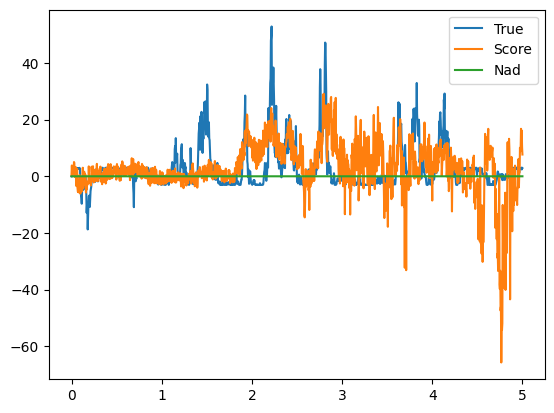

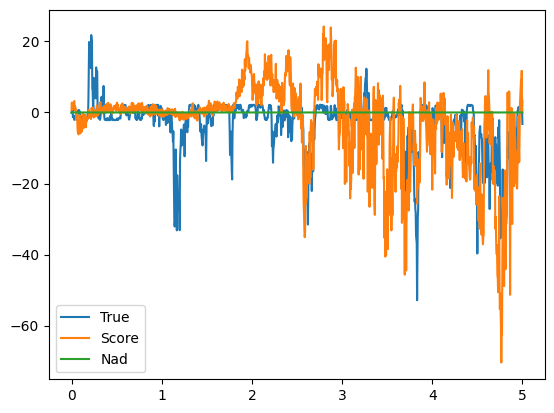

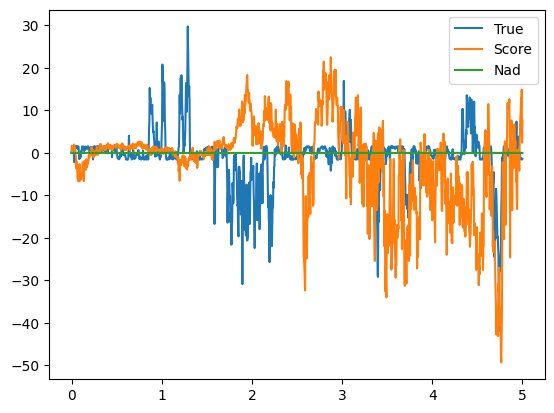

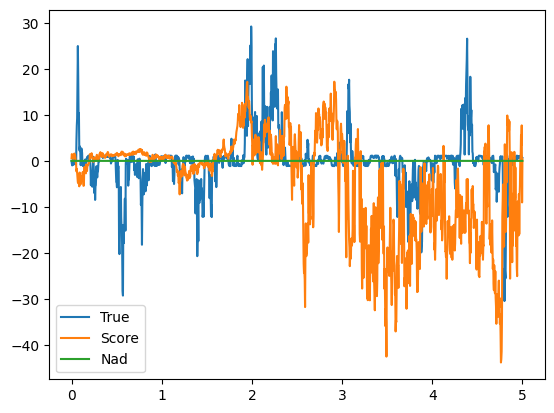

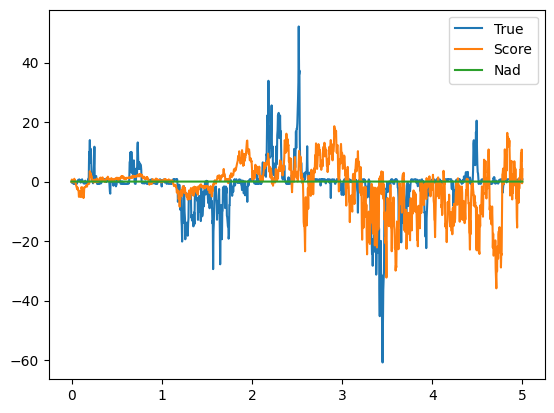

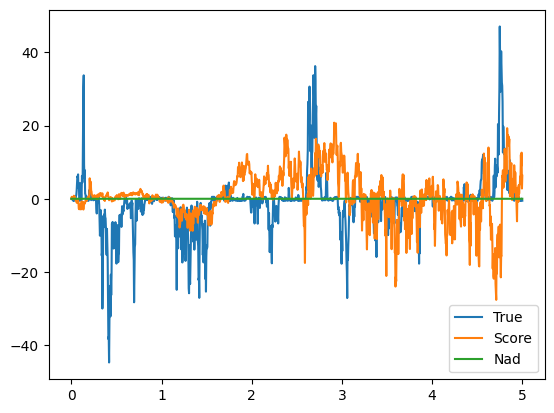

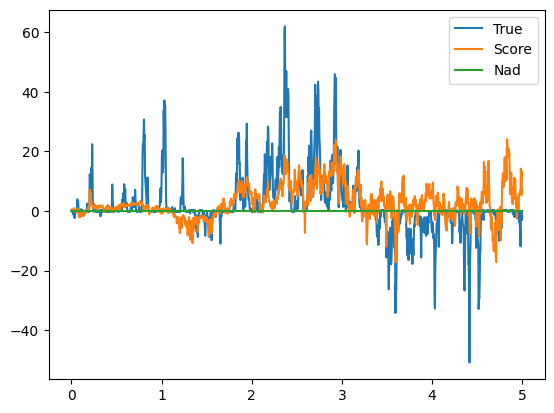

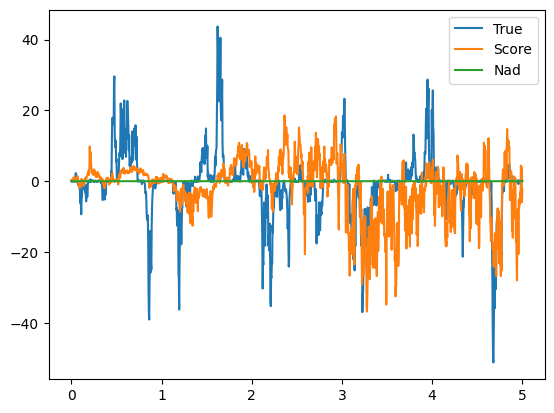

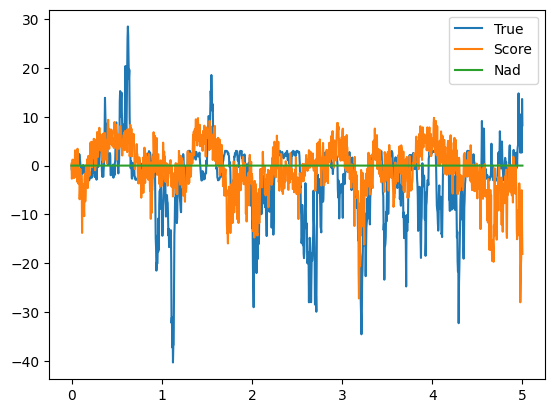

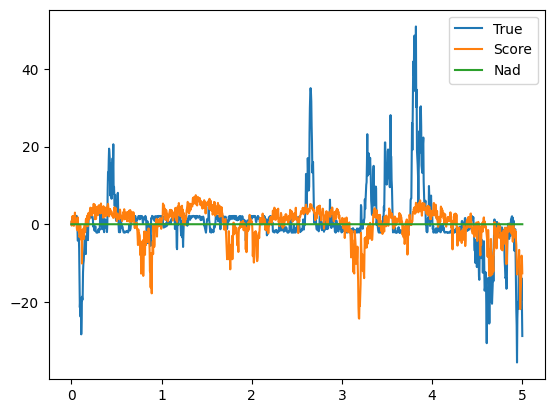

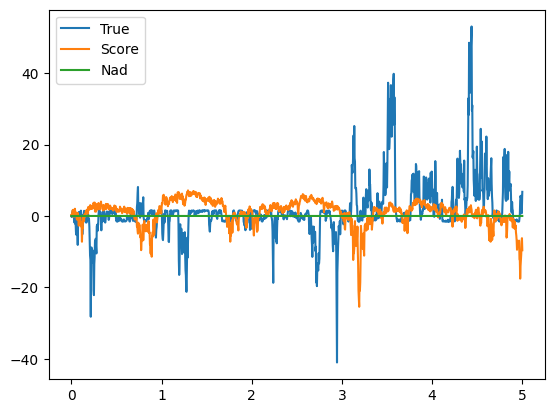

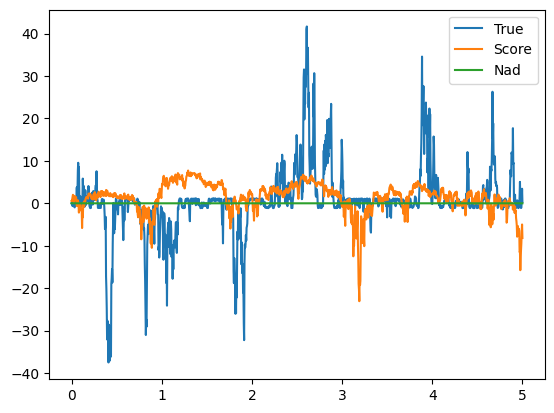

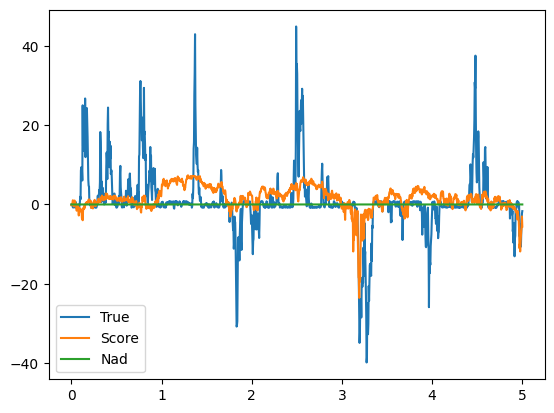

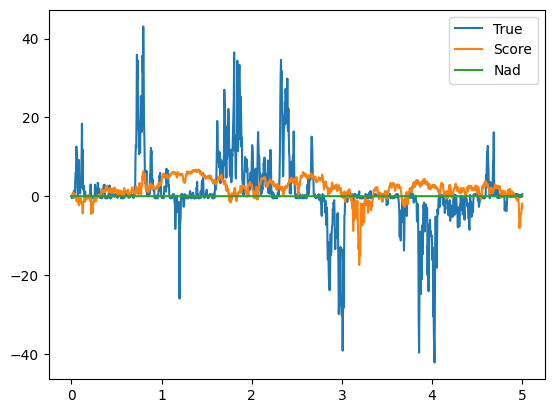

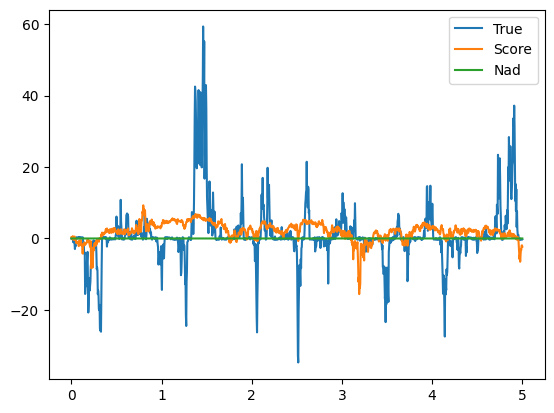

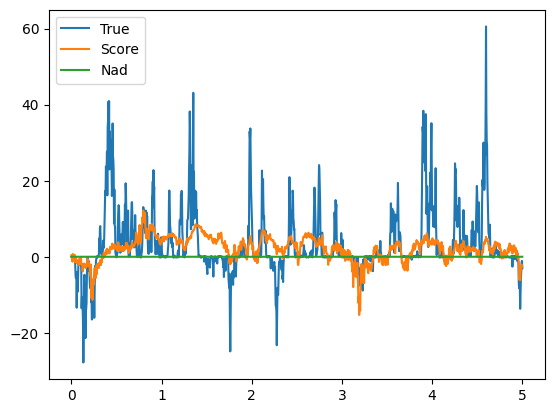

In [34]:
for k in range(2):
    for d in range(8):
        plt.plot(time_ax, true_paths[k, :, d], label="True")
        plt.plot(time_ax, score_paths[k, :, d], label="Score")
        plt.plot(time_ax, nad_paths[k, :, d], label="Nad")
        plt.legend()
        plt.show()
        plt.close()